## Spam Email Detection

### Initialisation

#### Import Libraries

In [125]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import wordcloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rishabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Import Dataset

In [126]:
df = pd.read_csv('emails.csv')
df.columns = ['Content','Label']
df['Label'].replace(to_replace=[1,0],value=['Spam','Not Spam'],inplace=True)
df.sample(5)

,Content,Label
4351,Subject: lng models can you guys please take ...,Not Spam
4226,"Subject: re : tony hamilton chris , e hired ...",Not Spam
4484,"Subject: meeting on feb 8 , 2001 dear sir , ...",Not Spam
34,Subject: ms 2003 software titles available for...,Spam
5051,Subject: re : trying to find fat tails naveen...,Not Spam


#### Value Counts


In [127]:
df.value_counts().sum()

5728

### Data Cleaning

#### Missing Value Analysis

In [128]:
df.isnull().sum()

Content    0
Label      0
dtype: int64

#### Duplicate Removal 

In [129]:
df.duplicated().sum()

33

In [130]:
df.drop_duplicates(inplace=True)
df.shape

(5695, 2)

#### Dataset Description

In [131]:
df.describe()

,Content,Label
count,5695,5695
unique,5695,2
top,Subject: naturally irresistible your corporate...,Not Spam
freq,1,4327


#### Shape

In [132]:
df.shape

(5695, 2)

### Exploratory Data Analysis

#### Label Distribution

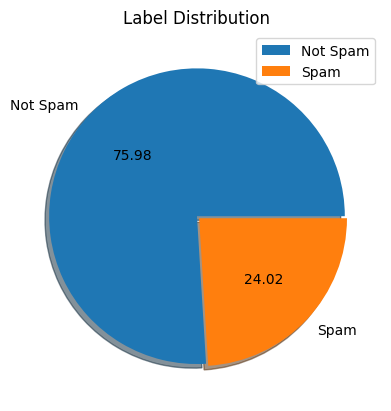

In [133]:
plt.pie(df['Label'].value_counts(),autopct="%0.2f",labels=['Not Spam','Spam'],explode=[0,0.02],shadow=True)
plt.legend(loc='best')
plt.title('Label Distribution')
plt.show()

#### Word Cloud 

##### Spam Mails

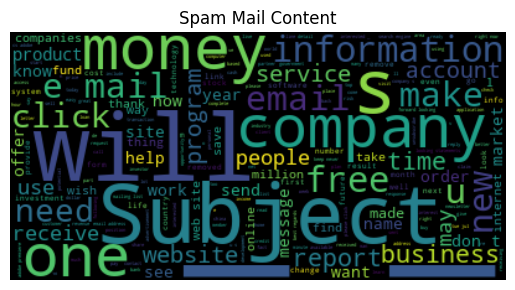

In [134]:
from wordcloud import WordCloud
text = " ".join(x for x in df[df['Label']=='Spam']['Content'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Spam Mail Content')
plt.show()

##### Not Spam Mails

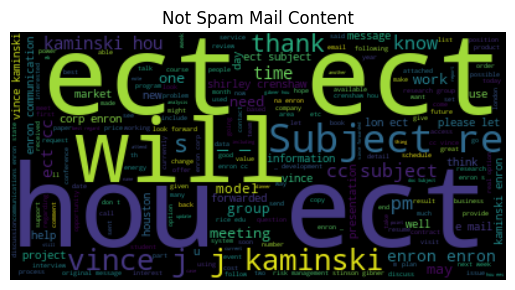

In [135]:
from wordcloud import WordCloud
text = " ".join(x for x in df[df['Label']=='Not Spam']['Content'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Not Spam Mail Content')
plt.show()

#### Analyse Counts

In [136]:
df['Characters'] = [len(x) for x in df['Content']]
df['Words'] = [len(x.split(" ")) for x in df['Content']]
df[['Characters','Words']].describe()

,Characters,Words
count,5695.000000,5695.000000
mean,1558.067076,358.137313
std,2047.078711,452.047939
min,13.000000,3.000000
25%,508.500000,112.500000
50%,979.000000,232.000000
75%,1893.000000,439.000000
max,43952.000000,8984.000000


##### Character Distribution

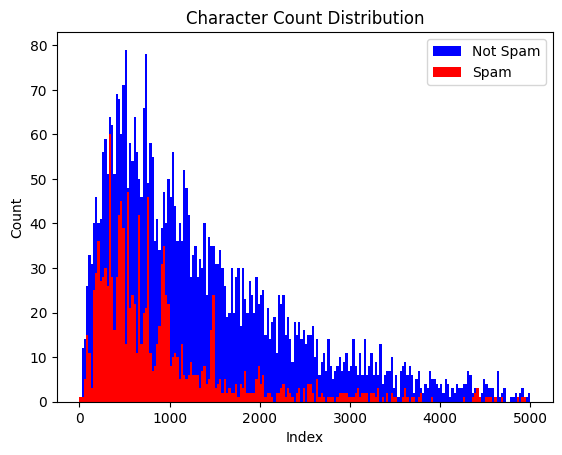

In [137]:
plt.hist(df[df['Label']=='Not Spam']['Characters'],bins=200,range=(0,5000),color='blue',label='Not Spam')
plt.hist(df[df['Label']=='Spam']['Characters'],bins=200,range=(0,5000),color='red',label='Spam')
plt.legend(loc="best")
plt.title("Character Count Distribution")
plt.xlabel('Index')
plt.ylabel('Count')
plt.show()

##### Word Distribution

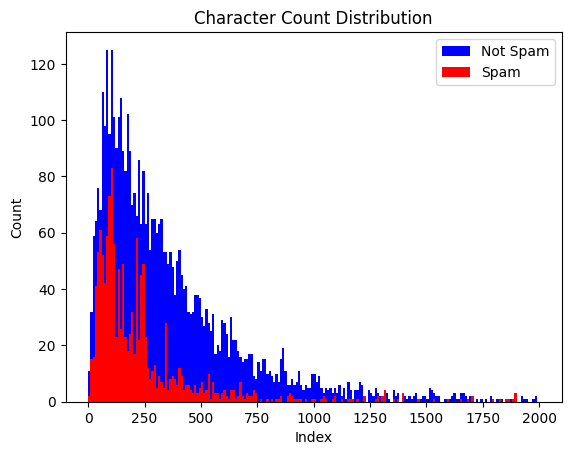

In [138]:
plt.hist(df[df['Label']=='Not Spam']['Words'],bins=200,range=(0,2000),color='blue',label='Not Spam')
plt.hist(df[df['Label']=='Spam']['Words'],bins=200,range=(0,2000),color='red',label='Spam')
plt.legend(loc="best")
plt.title("Character Count Distribution")
plt.xlabel('Index')
plt.ylabel('Count')
plt.show()

#### Pairplots

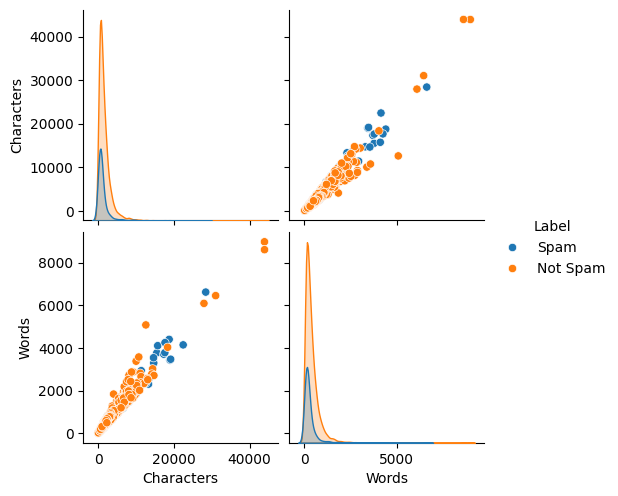

In [139]:
sb.pairplot(df,hue='Label')
plt.show()

#### Heatmap

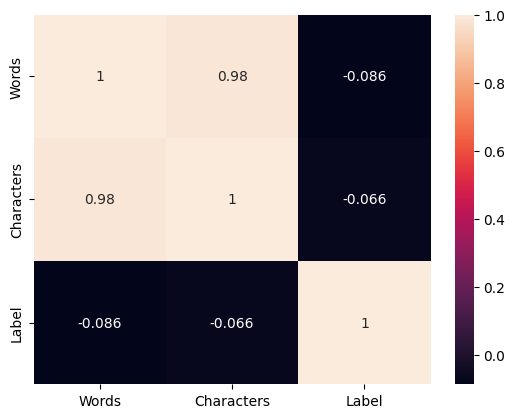

In [140]:
df.replace(to_replace=['Spam','Not Spam'],value=[1,0],inplace=True)
sb.heatmap(df[['Words','Characters','Label']].corr(),annot=True)
df.replace(to_replace=[1,0],value=['Spam','Not Spam'],inplace=True)

### Text Preprocessing

#### Remove Subject and Replied Notations

In [141]:
df['Content'] = [str.replace('subject: ','') for str in df['Content']]
df['Content'] = [str.replace('re : ','') for str in df['Content']]
df.sample(10)

,Content,Label,Characters,Words
5584,Subject: garp 2001 convention dear garp 2001 ...,Not Spam,2048,475
4874,"Subject: hari , i shall send you a reprint o...",Not Spam,1264,290
4241,Subject: f / u to dr . kaminski @ enron from i...,Not Spam,2247,631
1871,Subject: restricted stock deferral opportunity...,Not Spam,815,169
2607,Subject: houston trip hi jaideep ! my first ...,Not Spam,1535,379
5096,"Subject: 2001 budget for research sir , i ju...",Not Spam,837,202
5190,Subject: tony hamilton thanks for clarifying ...,Not Spam,2091,503
5203,Subject: hello team we are very excited to be...,Not Spam,441,106
3725,Subject: ll visa - anshuman shrivastava molly...,Not Spam,3922,929
908,Subject: mail delivery failed : returning mess...,Spam,1682,426


#### Porter Stemming

In [142]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_sentence(sentence):
    new=""
    for word in sentence.split(" "):
        new+=stemmer.stem(word.strip(',').strip('!').strip(' '))+" "
    return new

df['Content'] = [stem_sentence(row) for row in df['Content']]

### Model Preparation

#### Test-Train Split

In [143]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(df['Content'],df['Label'],test_size=0.3)

#### Vectorization

In [144]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

#### Handling Imbalance in Dataset

In [145]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1234)
X_sm, Y_sm = smote.fit_resample(X_train_cv,Y_train)

#### Model Fitting

In [146]:
from sklearn.naive_bayes import MultinomialNB  
model = MultinomialNB()
model.fit(X_sm,Y_sm)

MultinomialNB()

#### Prediction and Accuracy Test

In [147]:
from sklearn.metrics import accuracy_score,f1_score,precision_score
Y_predict = model.predict(X_test_cv)
print(f"Accuracy: {round(accuracy_score(Y_test,Y_predict)*100,3)}")
print(f"Precision: {round(precision_score(Y_test,Y_predict,labels=['Spam','Not Spam'],pos_label='Not Spam')*100,3)}")
print(f"F1 Score: {round(f1_score(Y_test,Y_predict,labels=['Spam','Not Spam'],pos_label='Not Spam')*100,3)}")

Accuracy: 99.239
Precision: 99.375
F1 Score: 99.492


#### Classification Summary


In [156]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_predict))

('              precision    recall  f1-score   support\n'
 '\n'
 '    Not Spam       0.99      1.00      0.99      1277\n'
 '        Spam       0.99      0.98      0.98       432\n'
 '\n'
 '    accuracy                           0.99      1709\n'
 '   macro avg       0.99      0.99      0.99      1709\n'
 'weighted avg       0.99      0.99      0.99      1709\n')


#### Confusion Matrix

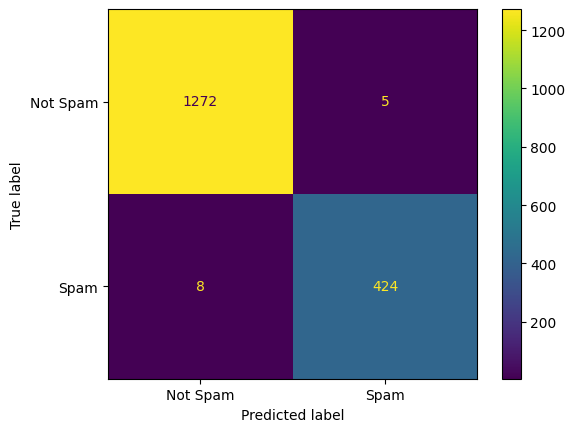

In [149]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test, Y_predict,labels=model.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = model.classes_)
cm_display.plot()
plt.show()

### TF-IDF Vectorizer

In [150]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,f1_score,precision_score,classification_report

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

smote = SMOTE(random_state=1234)
X_sm, Y_sm = smote.fit_resample(X_train_cv,Y_train)

model = MultinomialNB()
model.fit(X_sm,Y_sm)

Y_predict = model.predict(X_test_cv)
print(f"Accuracy: {round(accuracy_score(Y_test,Y_predict)*100,3)}")
print(f"Precision: {round(precision_score(Y_test,Y_predict,labels=['Spam','Not Spam'],pos_label='Not Spam')*100,3)}")
print(f"F1 Score: {round(f1_score(Y_test,Y_predict,labels=['Spam','Not Spam'],pos_label='Not Spam')*100,3)}")

Accuracy: 99.239
Precision: 99.375
F1 Score: 99.492


#### Classification Report

In [151]:
print(classification_report(Y_test,Y_predict))

              precision    recall  f1-score   support

    Not Spam       0.99      1.00      0.99      1277
        Spam       0.99      0.98      0.98       432

    accuracy                           0.99      1709
   macro avg       0.99      0.99      0.99      1709
weighted avg       0.99      0.99      0.99      1709



###### This proves that in this case using TF-IDF Vectorizer has been able to slightly improve the accuracy and individual f1-scores

### Model Saving and Storing

#### Model Pickling

In [152]:
import pickle
fm = open('pickles/model_pickle','wb')
pickle.dump(model,fm)

fv = open('pickles/vectorizer_pickle','wb')
pickle.dump(vectorizer,fv)